In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [21]:
file_path = 'train.csv'  
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,id,stmt_date,HQ_city,legal_struct,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,...,inc_extraord,taxes,profit,days_rec,ebitda,roa,roe,wc_net,margin_fin,cf_operations
0,17,520288,2011-12-31,28.0,SRL,14.0,NaT,2011,67537.0,1137566.0,...,-309.0,-80959.0,-81288.0,NaN,6318.0,-3.81,-28.03,496258.0,-917029.0,-849.0
1,18,520288,2008-12-31,28.0,SRL,14.0,NaT,2008,256438.0,1181416.0,...,-678.0,-94622.0,-107382.0,NaN,46088.0,-2.76,NaN,97952.0,NaN,-3881.0
2,19,520288,2009-12-31,28.0,SRL,14.0,NaT,2009,194046.0,1152014.0,...,4224.0,-74235.0,-77819.0,NaN,67611.0,-2.17,NaN,-210671.0,NaN,32618.0
3,21,520288,2012-12-31,28.0,SRL,14.0,NaT,2012,15195.0,1116938.0,...,3634.0,-250786.0,-250786.0,NaN,-161478.0,-12.99,NaN,367892.0,-1094962.0,-168907.0
4,22,520288,2007-12-31,28.0,SRL,14.0,NaT,2007,126603.0,1127807.0,...,820.0,92192.0,36733.0,NaN,153060.0,6.20,52.43,-317007.0,-1184970.0,80039.0


In [22]:
df.isna().sum()

Unnamed: 0                    0
id                            0
stmt_date                     0
HQ_city                     277
legal_struct                  0
ateco_sector                  0
def_date                      0
fs_year                       0
asst_intang_fixed           162
asst_tang_fixed             103
asst_fixed_fin              237
asst_current                  1
AR                           12
cash_and_equiv               17
asst_tot                      0
eqty_tot                      1
eqty_corp_family_tot    1023552
liab_lt                     294
liab_lt_emp                 162
debt_bank_st             121331
debt_bank_lt              90971
debt_fin_st              122772
debt_fin_lt               92068
AP_st                    120635
AP_lt                     92244
debt_st                       5
debt_lt                     155
rev_operating               174
COGS                         24
prof_operations              21
goodwill                     21
inc_fina

# Imputation Function
-------
This function will take in a df, aggregate column, and columns that sum to that column. If there is one null, we will take the difference between other columns and the aggregate column as the imputed value. If there is more than one we will take the average of the missing values in each.

In [23]:
def impute_multiple_nulls(df, agg_col, cols_to_sum):
    """
    Impute missing values in a set of columns that are supposed to sum up to an aggregated column.
    If one value is missing, it is imputed as the difference between the aggregated column and the sum of the non-null columns.
    If two or more values are missing, the missing values are replaced by the average difference to balance the total sum.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    agg_col (str): The name of the aggregated column.
    cols_to_sum (list of str): The list of column names that are supposed to sum to the aggregated column.
    
    Returns:
    pd.DataFrame: The dataframe with missing values imputed.
    """
    # Step 1: Identify rows with at least one null in the columns to sum
    df_with_nulls = df[df[cols_to_sum].isna().sum(axis=1) >= 1]
    
    # Step 2: Loop over rows with at least one null
    for index, row in df_with_nulls.iterrows():
        # Get the columns that are missing (NaN)
        missing_columns = row[cols_to_sum].isna()[row[cols_to_sum].isna()].index
        
        # Calculate the sum of the non-null columns
        non_null_sum = row[cols_to_sum].sum()  # Sum of non-null values in the columns to sum
        
        # Calculate the missing value(s)
        missing_value_total = row[agg_col] - non_null_sum
        
        # If there is exactly one missing value, assign it directly
        if len(missing_columns) == 1:
            df.at[index, missing_columns[0]] = missing_value_total
        # If there are two or more missing values, distribute the missing total equally among them
        else:
            avg_missing_value = missing_value_total / len(missing_columns)
            for col in missing_columns:
                df.at[index, col] = avg_missing_value
    
    return df


# TOTAL ASSETS AS SUM OF OTHER ASSETS FIELDS ON BALANCE SHEET:

# Total Assets Calc

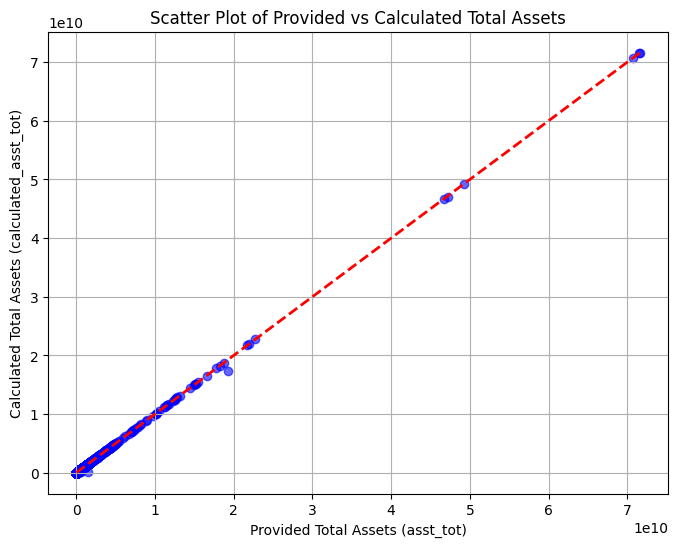

average_percent_difference between asst_intang_fixed + asst_tang_fixed + asst_fixed_fin + asst_current and total assets: 1.299050089047286


In [24]:
calculated_assets_total = (
    df['asst_intang_fixed'] + 
    df['asst_tang_fixed'] + 
    df['asst_fixed_fin'] + 
    df['asst_current']
)

# Compare calculated total assets with the provided total assets
df['calculated_asst_tot'] = calculated_assets_total

# Create a scatter plot comparing calculated total assets to provided total assets
plt.figure(figsize=(8, 6))
plt.scatter(df['asst_tot'], df['calculated_asst_tot'], color='blue', alpha=0.6)
plt.plot([df['asst_tot'].min(), df['asst_tot'].max()], [df['asst_tot'].min(), df['asst_tot'].max()], color='red', lw=2, linestyle='--')  # Line of equality
plt.title('Scatter Plot of Provided vs Calculated Total Assets')
plt.xlabel('Provided Total Assets (asst_tot)')
plt.ylabel('Calculated Total Assets (calculated_asst_tot)')
plt.grid(True)

# Display the plot
plt.show()

# Calculate percent difference
percent_difference = (df['calculated_asst_tot'] - df['asst_tot']).abs() / df['asst_tot'] * 100
# Calculate the average percent difference
average_percent_difference = percent_difference.mean()
print('average_percent_difference between asst_intang_fixed + asst_tang_fixed + asst_fixed_fin + asst_current and total assets:', average_percent_difference)

## Total Assets imputation

In [25]:
df_assets = df[['asst_tot', 'asst_intang_fixed', 'asst_tang_fixed', 'asst_fixed_fin', 'asst_current']]  # Add any other asset-related columns as needed
df_assets['null_count'] = df_assets.isna().sum(axis=1)
df_assets.groupby('null_count').size()

null_count
0    1023238
1        180
2         80
3         53
4          1
dtype: int64

In [26]:
df = impute_multiple_nulls(df, 'asst_tot', ['asst_intang_fixed', 'asst_tang_fixed', 'asst_fixed_fin', 'asst_current'])

In [27]:
df_assets = df[['asst_tot', 'asst_intang_fixed', 'asst_tang_fixed', 'asst_fixed_fin', 'asst_current']]  # Add any other asset-related columns as needed
df_assets['null_count'] = df_assets.isna().sum(axis=1)
df_assets.groupby('null_count').size()

null_count
0    1023552
dtype: int64

### Have majority of cases with only 1 null, lets replace

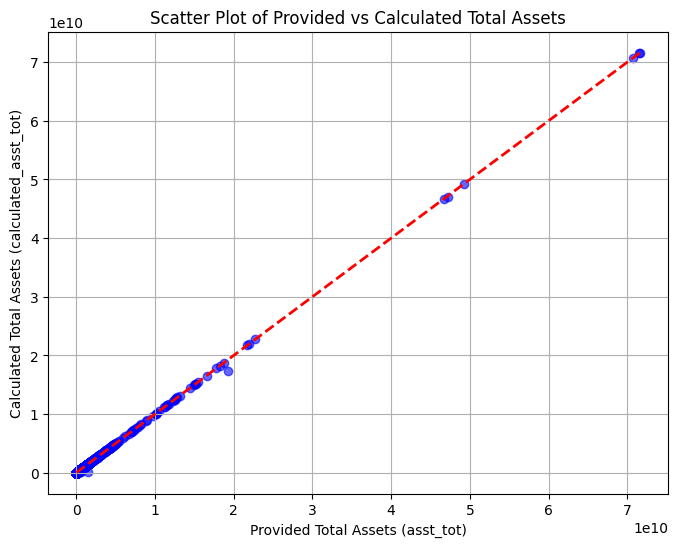

average_percent_difference between asst_intang_fixed + asst_tang_fixed + asst_fixed_fin + asst_current and total assets: 1.2986515731653758


In [28]:
calculated_assets_total = (
    df['asst_intang_fixed'] + 
    df['asst_tang_fixed'] + 
    df['asst_fixed_fin'] + 
    df['asst_current']
)

# Compare calculated total assets with the provided total assets
df['calculated_asst_tot'] = calculated_assets_total

# Create a scatter plot comparing calculated total assets to provided total assets
plt.figure(figsize=(8, 6))
plt.scatter(df['asst_tot'], df['calculated_asst_tot'], color='blue', alpha=0.6)
plt.plot([df['asst_tot'].min(), df['asst_tot'].max()], [df['asst_tot'].min(), df['asst_tot'].max()], color='red', lw=2, linestyle='--')  # Line of equality
plt.title('Scatter Plot of Provided vs Calculated Total Assets')
plt.xlabel('Provided Total Assets (asst_tot)')
plt.ylabel('Calculated Total Assets (calculated_asst_tot)')
plt.grid(True)

# Display the plot
plt.show()

# Calculate percent difference
percent_difference = (df['calculated_asst_tot'] - df['asst_tot']).abs() / df['asst_tot'] * 100
# Calculate the average percent difference
average_percent_difference = percent_difference.mean()
print('average_percent_difference between asst_intang_fixed + asst_tang_fixed + asst_fixed_fin + asst_current and total assets:', average_percent_difference)

In [29]:
df.isna().sum()

Unnamed: 0                    0
id                            0
stmt_date                     0
HQ_city                     277
legal_struct                  0
ateco_sector                  0
def_date                      0
fs_year                       0
asst_intang_fixed             0
asst_tang_fixed               0
asst_fixed_fin                0
asst_current                  0
AR                           12
cash_and_equiv               17
asst_tot                      0
eqty_tot                      1
eqty_corp_family_tot    1023552
liab_lt                     294
liab_lt_emp                 162
debt_bank_st             121331
debt_bank_lt              90971
debt_fin_st              122772
debt_fin_lt               92068
AP_st                    120635
AP_lt                     92244
debt_st                       5
debt_lt                     155
rev_operating               174
COGS                         24
prof_operations              21
goodwill                     21
inc_fina

# ASSETS = LIABILITIES + EQUITY

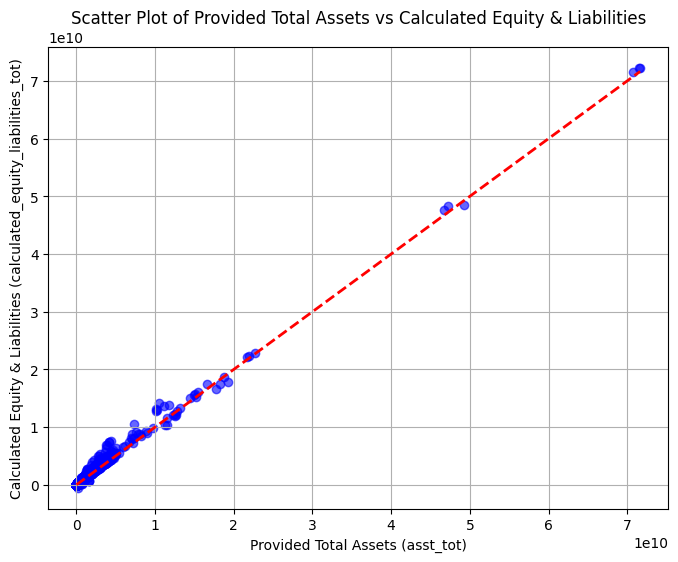

np.float64(16.84240496578406)

In [30]:
# Using the previous dataframe to calculate total equity and liabilities
calculated_equity_liabilities_total = (
    df['eqty_tot'] + 
    df['liab_lt'] + 
    df['debt_st'] + 
    df['debt_lt'] + 
    df['AP_st'] + 
    df['AP_lt']
)

# Compare calculated total equity & liabilities with the provided total assets
df['calculated_equity_liabilities_tot'] = calculated_equity_liabilities_total

# Create a scatter plot comparing calculated total equity & liabilities to provided total assets
plt.figure(figsize=(8, 6))
plt.scatter(df['asst_tot'], df['calculated_equity_liabilities_tot'], color='blue', alpha=0.6)
plt.plot([df['asst_tot'].min(), df['asst_tot'].max()], [df['asst_tot'].min(), df['asst_tot'].max()], color='red', lw=2, linestyle='--')  # Line of equality
plt.title('Scatter Plot of Provided Total Assets vs Calculated Equity & Liabilities')
plt.xlabel('Provided Total Assets (asst_tot)')
plt.ylabel('Calculated Equity & Liabilities (calculated_equity_liabilities_tot)')
plt.grid(True)

# Display the plot
plt.show()

# Calculate percent difference between provided total assets and calculated equity & liabilities
percent_difference = (df['calculated_equity_liabilities_tot'] - df['asst_tot']).abs() / df['asst_tot'] * 100

# Calculate the average percent difference
average_percent_difference = percent_difference.mean()

# Output the average percent difference
average_percent_difference


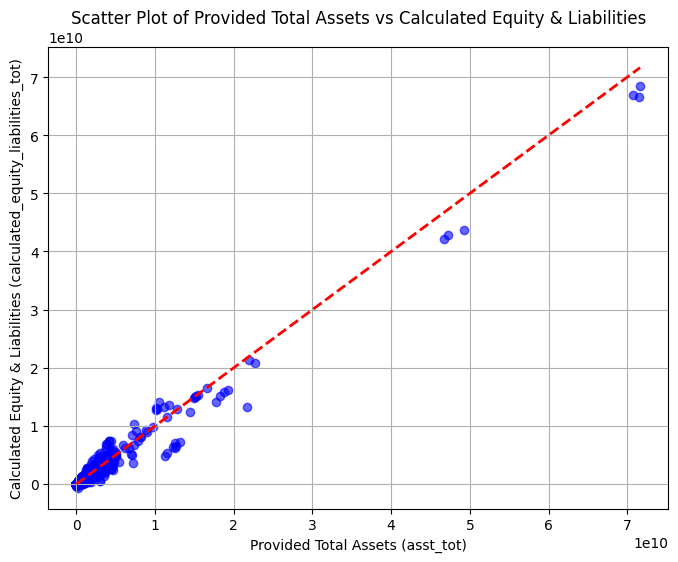

np.float64(28.167833755015085)

In [18]:
# Using the previous dataframe to calculate total equity and liabilities
calculated_equity_liabilities_total = (
    df['eqty_tot'] + 
    df['liab_lt'] + 
    df['debt_st'] + 
    df['AP_st'] 
)

# Compare calculated total equity & liabilities with the provided total assets
df['calculated_equity_liabilities_tot'] = calculated_equity_liabilities_total

# Create a scatter plot comparing calculated total equity & liabilities to provided total assets
plt.figure(figsize=(8, 6))
plt.scatter(df['asst_tot'], df['calculated_equity_liabilities_tot'], color='blue', alpha=0.6)
plt.plot([df['asst_tot'].min(), df['asst_tot'].max()], [df['asst_tot'].min(), df['asst_tot'].max()], color='red', lw=2, linestyle='--')  # Line of equality
plt.title('Scatter Plot of Provided Total Assets vs Calculated Equity & Liabilities')
plt.xlabel('Provided Total Assets (asst_tot)')
plt.ylabel('Calculated Equity & Liabilities (calculated_equity_liabilities_tot)')
plt.grid(True)

# Display the plot
plt.show()

# Calculate percent difference between provided total assets and calculated equity & liabilities
percent_difference = (df['calculated_equity_liabilities_tot'] - df['asst_tot']).abs() / df['asst_tot'] * 100

# Calculate the average percent difference
average_percent_difference = percent_difference.mean()

# Output the average percent difference
average_percent_difference


### this seems like the most reasonable

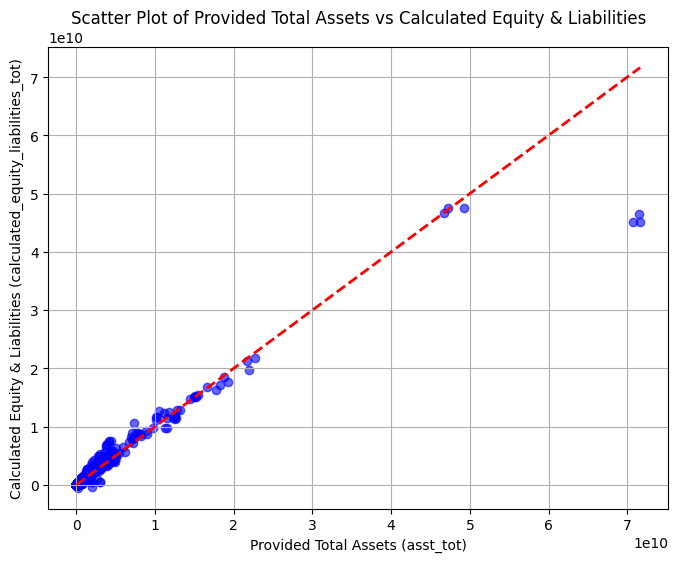

np.float64(16.7001427751732)

In [19]:
# Using the previous dataframe to calculate total equity and liabilities
calculated_equity_liabilities_total = (
    df['eqty_tot'] + 
    df['debt_st'] + 
    df['debt_lt'] + 
    df['AP_st'] + 
    df['AP_lt']
)

# Compare calculated total equity & liabilities with the provided total assets
df['calculated_equity_liabilities_tot'] = calculated_equity_liabilities_total

# Create a scatter plot comparing calculated total equity & liabilities to provided total assets
plt.figure(figsize=(8, 6))
plt.scatter(df['asst_tot'], df['calculated_equity_liabilities_tot'], color='blue', alpha=0.6)
plt.plot([df['asst_tot'].min(), df['asst_tot'].max()], [df['asst_tot'].min(), df['asst_tot'].max()], color='red', lw=2, linestyle='--')  # Line of equality
plt.title('Scatter Plot of Provided Total Assets vs Calculated Equity & Liabilities')
plt.xlabel('Provided Total Assets (asst_tot)')
plt.ylabel('Calculated Equity & Liabilities (calculated_equity_liabilities_tot)')
plt.grid(True)

# Display the plot
plt.show()

# Calculate percent difference between provided total assets and calculated equity & liabilities
percent_difference = (df['calculated_equity_liabilities_tot'] - df['asst_tot']).abs() / df['asst_tot'] * 100

# Calculate the average percent difference
average_percent_difference = percent_difference.mean()

# Output the average percent difference
average_percent_difference


## Not exactly sure what to do here...

# Debt categories imputation

In [31]:
df = impute_multiple_nulls(df, 'debt_st', ['debt_bank_st', 'debt_fin_st'])
df = impute_multiple_nulls(df, 'debt_lt', ['debt_bank_lt', 'debt_fin_lt'])
df.isna().sum()

Unnamed: 0                                 0
id                                         0
stmt_date                                  0
HQ_city                                  277
legal_struct                               0
ateco_sector                               0
def_date                                   0
fs_year                                    0
asst_intang_fixed                          0
asst_tang_fixed                            0
asst_fixed_fin                             0
asst_current                               0
AR                                        12
cash_and_equiv                            17
asst_tot                                   0
eqty_tot                                   1
eqty_corp_family_tot                 1023552
liab_lt                                  294
liab_lt_emp                              162
debt_bank_st                               4
debt_bank_lt                             150
debt_fin_st                                4
debt_fin_l

In [32]:
df.to_csv('../data/imputed_train.csv',index=False)

# What do we need right now:
-----


### Risk Calculation Formulas with Null Counts

1. **Assets Total**:
   $$
   \text{asst_tot} = \text{asst_intang_fixed} + \text{asst_tang_fixed} + \text{asst_fixed_fin} + \text{asst_current}
   $$
   - **Nulls**:  
     - asst_intang_fixed: 162  
     - asst_tang_fixed: 103  
     - asst_fixed_fin: 237  
     - asst_current: 1
     - asst_tot: 0

2. **Liabilities Total**:
   $$
   \text{liab_tot} = \text{debt_st} + \text{debt_lt} + \text{AP_st} + \text{AP_lt}
   $$
   - **Nulls**:  
     - debt_st: 5  
     - debt_lt: 155  
     - AP_st: 120,635  
     - AP_lt: 92,244
   
   Alternatively, simplified:
   $$
   \text{liab_tot} = \text{debt_st} + \text{debt_lt}
   $$
   - **Nulls**:  
     - debt_st: 5  
     - debt_lt: 155

3. **Total Assets vs. Liabilities + Equity**:
   $$
   \text{calculated_liabilities_equity} = \text{liab_tot} + \text{eqty_tot}
   $$
   - **Nulls**:  
     - eqty_tot: 1

4. **Financial Leverage** (Liabilities to Assets Ratio):
   $$
   \text{financial_leverage} = \frac{\text{liab_tot}}{\text{asst_tot}}
   $$
   - **Nulls**:  
     - liab_tot: (derived, based on nulls in debt and AP)

5. **Profitability Ratio** (Net Income to Assets):
   $$
   \text{profitability_ratio} = \frac{\text{profit}}{\text{asst_tot}}
   $$
   - **Nulls**:  
     - profit: 20  
     - asst_tot: 0

6. **Quick Ratio** (Liquidity):
   
   **Version 1** (Cash + Net Receivables / Current Liabilities):
   $$
   \text{quick_ratio_v1} = \frac{\text{cash_and_equiv} + \text{net_receivables}}{\text{debt_st}}
   $$
   where
   $$
   \text{net_receivables} = \text{AR} - (\text{AP_st} + \text{AP_lt})
   $$
   - **Nulls**:  
     - cash_and_equiv: 17  
     - AR: 12  
     - AP_st: 120,635  
     - AP_lt: 92,244  
     - debt_st: 5
   
   **Version 2** (Cash + Receivables / Current Liabilities):
   $$
   \text{quick_ratio_v2} = \frac{\text{cash_and_equiv} + \text{AR}}{\text{debt_st}}
   $$
   - **Nulls**:  
     - cash_and_equiv: 17  
     - AR: 12  
     - debt_st: 5

7. **Cash to Assets Ratio**:
   $$
   \text{cash_assets_ratio} = \frac{\text{cash_and_equiv}}{\text{asst_tot}}
   $$
   - **Nulls**:  
     - cash_and_equiv: 17  
     - asst_tot: 0

8. **Debt Service Coverage Ratio (DSCR)**:
   $$
   \text{dscr} = \frac{\text{ebitda}}{\text{exp_financing}}
   $$
   where $\text{exp_financing}$ is set to 1 if it is 0 to avoid division errors.
   - **Nulls**:  
     - ebitda: 81  
     - exp_financing: 367
